In [10]:
# pip install pmdarima
# auto arima를 자동으로 찾아준다

In [11]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import pmdarima as pm
# warning메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [12]:
# 삼성주식 찾기

df_krx = fdr.StockListing('KRX')
df_krx.head(3)
ticker=df_krx[df_krx['Name']=='삼성전자']['Code']

In [13]:
# 2020-01-01부터 삼성주가
ss=fdr.DataReader(''.join(ticker.values),'2020-01-01')
ss

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921
...,...,...,...,...,...,...
2023-06-02,71700,72200,71600,72200,12161798,0.018336
2023-06-05,72700,72700,71400,71700,12686829,-0.006925
2023-06-07,71300,71600,70800,71000,14796613,-0.009763


## 시계열 train,test set 분리하기

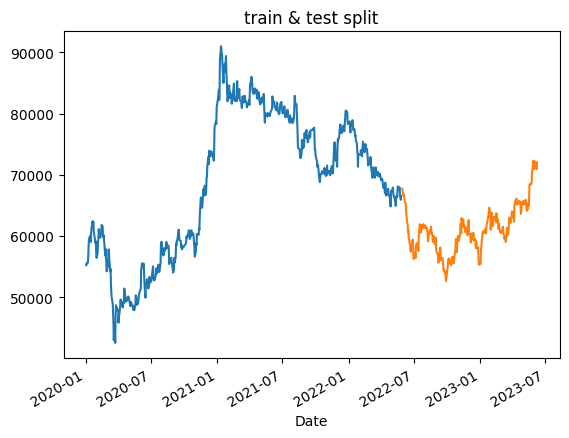

In [14]:
# train set, test set으로 구분하기(7:3)
y_train = ss['Close'][:int(0.7*len(ss))]
y_test = ss['Close'][int(0.7*len(ss)):]
plt.subplot()
plt.title('train & test split')
y_train.plot()
y_test.plot()
plt.show()

> pmdarima.arima.ndiffs 함수는 ARIMA 모델에 적합한 차분(Differencing) 횟수를 추정하는 데 사용되는 함수
- ARIMA 모델은 시계열 데이터의 추세(Trend)와 계절성(Seasonality)을 모델링하는 데 사용, 차분이용해서 제거
- timeseries: 분석하려는 시계열 데이터 (1차원 배열 또는 Pandas Series)
- test: 차분 횟수를 결정하기 위해 사용할 테스트 방법을 지정
    - 기본값은 "kpss"로 KPSS(Kwiatkowski-Phillips-Schmidt-Shin) 테스트
    - "adf" (ADF(Augmented Dickey-Fuller) 테스트) 
    - "pp" (Phillips-Perron) 테스트
- max_d: 최대 차분 횟수를 지정, 기본값은 2
- seasonal: 계절성을 가지는 시계열인 경우 True로 설정, 기본값은 False

In [15]:
# pmdarima.arima.ndiffs를 활용한 차분 필요 여부 및 추정차수

kpss_diffs=pm.arima.ndiffs(y_train,alpha=0.05,test='kpss',max_d=6)
adf_diffs=pm.arima.ndiffs(y_train,alpha=0.05,test='adf',max_d=6)
max(kpss_diffs,adf_diffs)

## 즉 arima모델에서 d를 1로 잡자

1

In [16]:
# log를 활용한 변동선 완화

ss_log=np.log(ss)

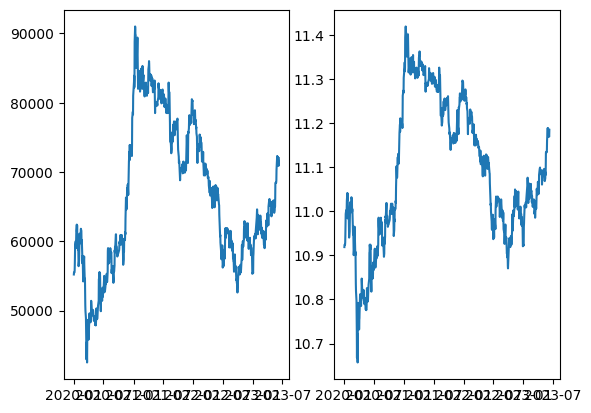

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(ss['Close'])

ax2.plot(ss_log['Close'])

plt.show()

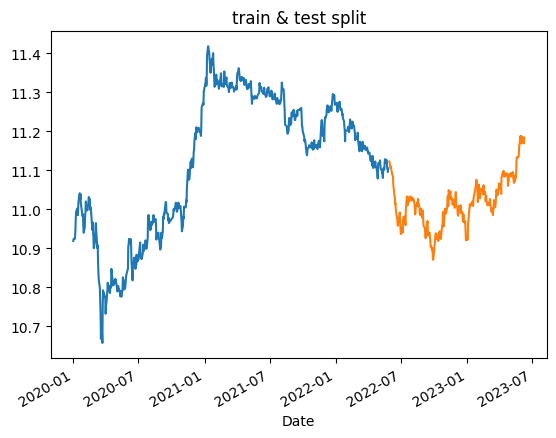

In [18]:
# train set, test set으로 구분하기(7:3)
y_train = ss_log['Close'][:int(0.7*len(ss))]
y_test = ss_log['Close'][int(0.7*len(ss)):]
plt.subplot()
plt.title('train & test split')
y_train.plot()
y_test.plot()
plt.show()

## 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

- AR(p) : ACF 가 완만하게 감소, PACF가 갑자기 cut-off
- MR(q) : ACF가 cut-off , PACF가 완만하게 감소
- ARMA(p,q) : ACF, PACF가 완만하게 감소

* p,q값에 주관이 들어갈 수 있다

### Augmented Dickey-Fuller test
- stationary를 확인해보는 방법
- from statsmodels.tsa.stattools import adfuller
-  p_value가 넘는지 안넘는지를 보면 된다
    - result = adfuller(inputSeries)
    - print('p-value: %f' % result[1])
- H0(귀무가설) : stationary 하지 않다
- H1(대립가설) : stationary 하다 
- 즉 p-value가 임계치보다 낮으면 H0를 기각하고, H1을 채택--> 즉 stationary하다

In [19]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

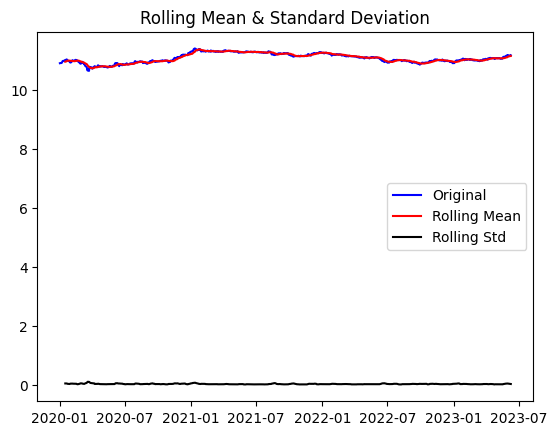

In [21]:
plot_rolling_statistics(ss_log['Close'])

In [22]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [23]:
augmented_dickey_fuller_test(ss_log['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.635059
p-value                          0.464844
#Lags Used                       0.000000
Number of Observations Used    849.000000
Critical Value (1%)             -3.438076
Critical Value (5%)             -2.864950
Critical Value (10%)            -2.568586
dtype: float64



정성적 그래프 분석 :


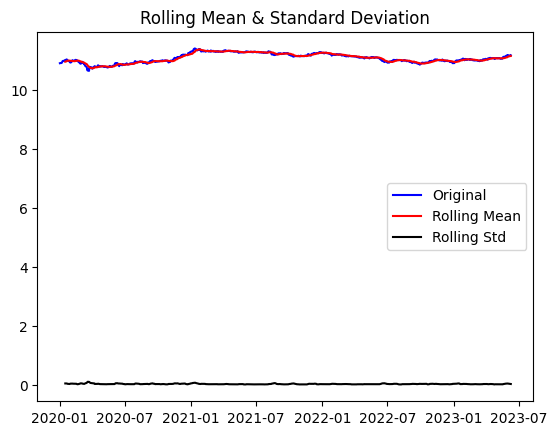


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                  -1.635059
p-value                          0.464844
#Lags Used                       0.000000
Number of Observations Used    849.000000
Critical Value (1%)             -3.438076
Critical Value (5%)             -2.864950
Critical Value (10%)            -2.568586
dtype: float64

시계열 분해 (Time Series Decomposition) :


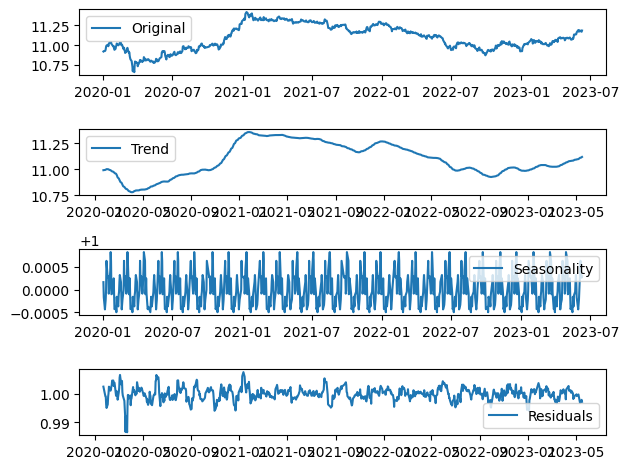

In [24]:
print()
print('\033[31m'+'\033[1m' + "정성적 그래프 분석 :" + '\033[0m')
# 정성적 그래프 분석
plot_rolling_statistics(ss_log['Close'], window=12)

print()
print('\033[31m'+'\033[1m' + "정량적 Augmented Dicky-Fuller Test :" + '\033[0m')
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ss_log['Close'])

print()
print('\033[31m'+'\033[1m' + "시계열 분해 (Time Series Decomposition) :" + '\033[0m')
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ss_log['Close'], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ss_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

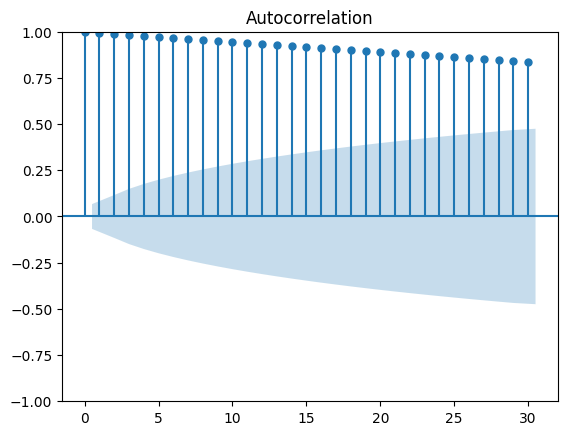

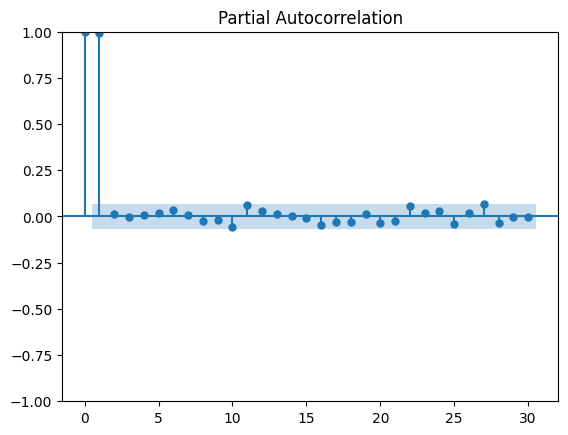

In [25]:
# ACF , PACF 그래프 확인
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ss_log['Close'])
plot_pacf(ss_log['Close'])
plt.show()

In [26]:
## AR(2)로 2번 차분을 할 예정(cut-off가 2이다)
## 차분을 통해서 정상성 확보
print('1차 차분')
diff_1 =ss_log.diff(periods=1)
diff_1=diff_1['Close'].iloc[1:]
#diff_1
augmented_dickey_fuller_test(diff_1)

1차 차분
Results of Dickey-Fuller Test:
Test Statistic                 -29.315115
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    848.000000
Critical Value (1%)             -3.438085
Critical Value (5%)             -2.864954
Critical Value (10%)            -2.568588
dtype: float64


In [27]:
print('2차 차분')
diff_2 =ss_log.diff(periods=1)
diff_2=diff_2['Close'].iloc[1:]
augmented_dickey_fuller_test(diff_2)

2차 차분
Results of Dickey-Fuller Test:
Test Statistic                 -29.315115
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    848.000000
Critical Value (1%)             -3.438085
Critical Value (5%)             -2.864954
Critical Value (10%)            -2.568588
dtype: float64


### pmdarima.arima.auto_arima
- pmdarima.arima.auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)

In [28]:
model=pm.arima.auto_arima(
    y=y_train , d=1,
    start_P=0, max_p=3,
    start_Q=0, max_q=3,
    m=1, seasonal=False,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3155.808, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3162.358, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3160.361, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3160.359, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3164.152, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3158.881, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.722 seconds


In [29]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  595
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1583.076
Date:                Sun, 11 Jun 2023   AIC                          -3164.152
Time:                        17:06:59   BIC                          -3159.765
Sample:                             0   HQIC                         -3162.444
                                - 595                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003      1e-05     28.289      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               306.75
Prob(Q):                              0.95   Pr

### Ljung-Box(융박스)
- H0 (귀무가설):융박스가 백색잡음이다 ----> 그러면 stationary이다
- H1 (대립가설):융박스가 백색잡음이 아니다---> 그러면 stationary하지 않는다 --> 차분을 해야함

### Jarque-Bera(자크 베라)
- H0 (귀무가설): 정상성을 띄고 있다
- H1 (대립가설): 정상성을 띄고 있지 않다

### Heteroskedasticity
- H0 (귀무가설) : 이분산성을 띄고 있다
- H1 (대립가설) : 이분산성을 띄지 않는다(등분산성의 성질을 갖는다)

### Skew:
- 왜도(치우쳐진 정도, 0에 가까울수록 가운데에 모인다)
- 0에 가까우면 정규분포를 띈다

### Kurtosis
- 첨도(뾰족한 정도)
- 정규분포의 첨도는 3이다.
- 3보다 크면 뾰족해지고, 3보다 작으면 완만해진다

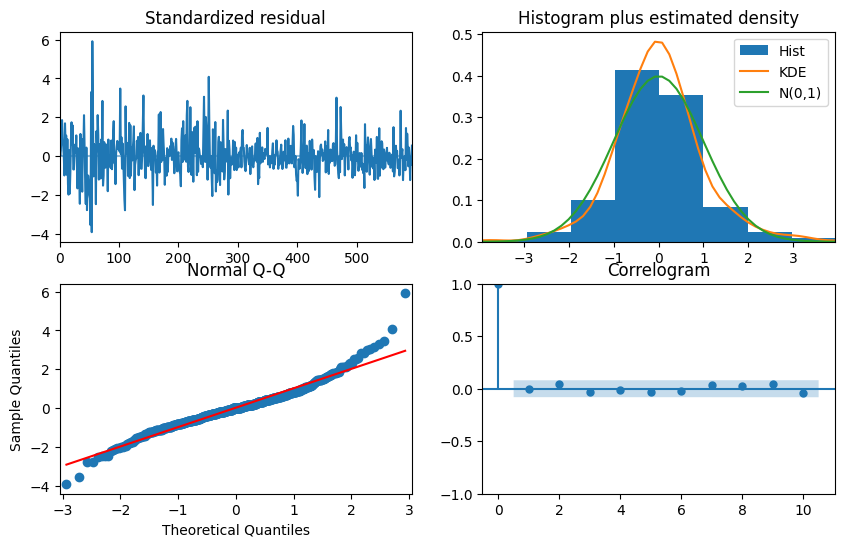

In [30]:
# model.plot_diagnostics 이용해서 그래프를 확인하기

model.plot_diagnostics(figsize=(10,6))
plt.show()

In [31]:
## 테스트 데이터를 통한 예측

y_predict = model.predict(n_periods=len(y_test))
y_predict_df= pd.DataFrame(y_predict.values,index=y_test.index,columns=['predictions'])
y_predict_df

,predictions
Date,
2022-05-30,11.104957
2022-05-31,11.104957
2022-06-02,11.104957
2022-06-03,11.104957
2022-06-07,11.104957
...,...
2023-06-02,11.104957
2023-06-05,11.104957
2023-06-07,11.104957


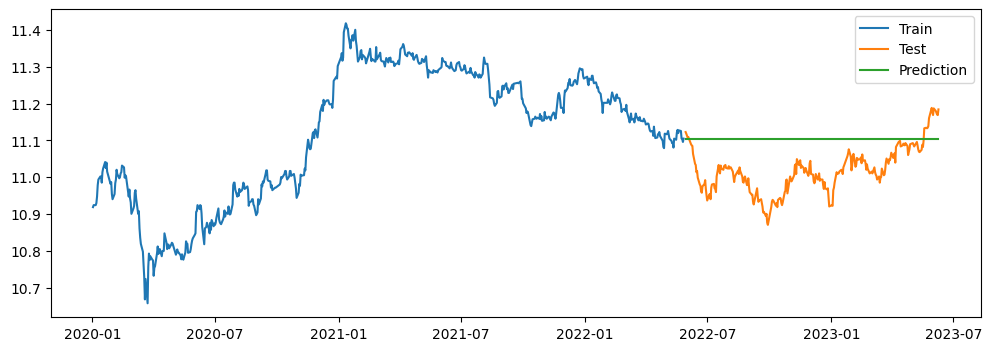

In [32]:
# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict_df, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [33]:
def forecast_one_step():
    fc,conf_int= model.predict(n_periods=1,return_conf_int=True)
    return (fc.tolist()[0],np.asarray(conf_int).tolist()[0])

In [34]:
forcasts=[]
y_pred=[]
pred_upper=[]
pred_lower=[]

for new_ob in y_test:
    fc,conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## model update
    model.update(new_ob)

In [35]:
pd.DataFrame({"test":y_test,"pred":y_pred})

,test,pred
Date,,
2022-05-30,11.122841,11.104957
2022-05-31,11.118400,11.122841
2022-06-02,11.107960,11.118400
2022-06-03,11.109458,11.107960
2022-06-07,11.089805,11.109458
...,...,...
2023-06-02,11.187195,11.169026
2023-06-05,11.180246,11.187195
2023-06-07,11.170435,11.180246


In [36]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  850
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2287.132
Date:                Sun, 11 Jun 2023   AIC                          -4572.264
Time:                        17:08:07   BIC                          -4567.520
Sample:                             0   HQIC                         -4570.447
                                - 850                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   8.41e-06     31.799      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               298.23
Prob(Q):                              0.81   Pr

In [37]:
# pip install plotly

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()